### Imports

In [17]:
import pandas as pd
from fastai.vision.all import *
from fastai.utils.mem import *

ModuleNotFoundError: No module named 'fastai.utils'

In [5]:
import pathlib
import os

In [6]:
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data")
path

'/home/carrotpie/code/classB/SegmentationLearner/Assets/Data'

In [7]:
codes = pd.read_csv(os.path.join(path,'labels.csv'))
codes.head()

,LabelName,LabelColor_Red,LabelColor_Green,LabelColor_Blue
0,building_wall,0,110,0
1,building_floor,0,120,0
2,building_ceiling,0,130,0
3,building_door,0,140,0
4,furniture_doubleBed,110,0,0


In [8]:
codes.shape

(21, 4)

In [18]:
?MaskBlock

Signature: MaskBlock(codes=None)
Docstring: A `TransformBlock` for segmentation masks, potentially with `codes`
File:      ~/code/classB/classB_env/lib/python3.6/site-packages/fastai/vision/data.py
Type:      function


In [9]:
fnames = get_image_files(os.path.join(path,"screenshots"))
fnames[0]

Path('/home/carrotpie/code/classB/SegmentationLearner/Assets/Data/screenshots/75.png')

In [10]:
def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")

In [16]:
mask = open_mask(label_func(fnames[0]))
mask.show(figsize=(5,5), alpha=1)

NameError: name 'open_mask' is not defined

In [11]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, item_tfms=Resize(256)
)

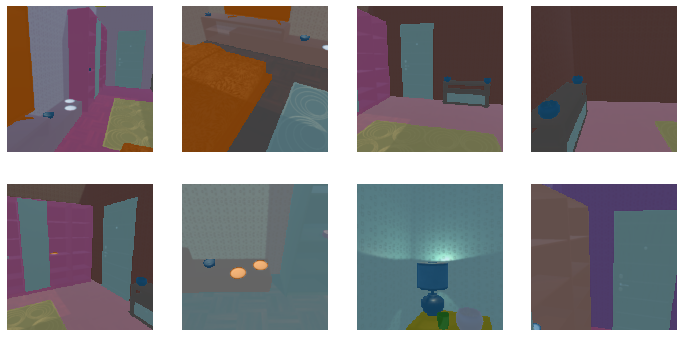

In [12]:
dls.show_batch(max_n=20)

In [13]:
learn = unet_learner(dls, resnet34, n_out = codes.shape[0]).to_fp16()

In [14]:
learn.model = learn.model.cpu()

In [15]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,time


RuntimeError: CUDA error: device-side assert triggered